In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, copy, warnings
warnings.filterwarnings("ignore")

In [2]:
data = pickle.load(open('data/inverse/cust_id.pkl', 'rb'))

In [3]:
date = None
for k1, v1 in data.items():
    for k2, v2 in v1.items():
        count = 0 # 每小時交易次數
        max_count = 0 # 樣本中最大的每小時交易次數
        sum_count = 0
        hour = 0
        for v3 in v2["data"]:
            if v3["source"] == 2:
                if date != v3["date"]:
                    date = v3["date"]
                    count = 1
                    hour += 1
                else:
                    count += 1

                sum_count += 1
                max_count = max(max_count, count)
        
        
        freq = sum_count/hour if hour != 0 else 0
        v2["data"][-1]["dp_freq"] = freq
        v2["data"][-1]["dp_count"] = max_count
        # print(k1, k2, max_count, sum_count, hour, freq)

In [4]:
# 所有sample加上sar，並分開各來源的資料
info = []
for k1, v1 in data.items():
    for k2, v2 in v1.items():
        for v3 in v2["data"]:
            if v3["source"] == 4:
                info.extend([v3])
info = pd.DataFrame(info)

In [14]:
target = "sar_flag"

In [17]:
train = info[~info[target].isnull()]
test = info[info[target].isnull()]

<AxesSubplot:xlabel='dp_freq', ylabel='sar_flag'>

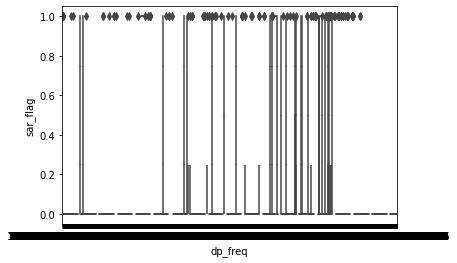

In [19]:
sns.boxplot(x = "dp_freq", y = "sar_flag", data = train)

In [7]:
info.query("(sar_flag == 1)").describe()

,alert_key,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE,source,dp_freq,dp_count
count,234.000000,234.0,234.000000,234.000000,234.000000,2.340000e+02,234.000000,234.0,234.000000,234.000000
mean,230223.884615,1.0,3331.226496,1.179487,13.799145,6.466978e+05,3.333333,4.0,2.278196,8.867521
std,42148.542556,0.0,1498.129926,0.525984,5.198035,1.728137e+06,1.193689,0.0,1.327888,24.839303
min,171770.000000,1.0,40.000000,1.000000,1.000000,0.000000e+00,1.000000,4.0,0.000000,0.000000
25%,196276.500000,1.0,2346.250000,1.000000,12.000000,7.739500e+03,2.000000,4.0,1.500000,4.000000
50%,216666.500000,1.0,3211.500000,1.000000,15.000000,1.071490e+05,3.000000,4.0,2.000000,6.000000
75%,257296.750000,1.0,4294.250000,1.000000,18.000000,5.061942e+05,4.000000,4.0,2.788534,8.000000
max,351367.000000,1.0,7216.000000,3.000000,19.000000,1.442488e+07,8.000000,4.0,11.991432,372.000000


In [8]:
info.query("(sar_flag == 0)").describe()

,alert_key,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE,source,dp_freq,dp_count
count,23672.000000,23672.0,23672.000000,23672.000000,23556.000000,2.367200e+04,23672.000000,23672.0,23672.000000,23672.000000
mean,258784.706446,0.0,3155.468233,1.622592,14.280735,7.201630e+05,3.647516,4.0,1.896072,3.683001
std,54638.578131,0.0,2166.304119,0.911491,4.666407,2.509574e+06,1.312788,0.0,3.002194,6.945515
min,171142.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,4.0,0.000000,0.000000
25%,208822.750000,0.0,1330.000000,1.000000,12.000000,6.698000e+03,3.000000,4.0,1.000000,1.000000
50%,259822.500000,0.0,3119.000000,1.000000,15.000000,1.247560e+05,3.000000,4.0,1.365723,2.000000
75%,306222.500000,0.0,5094.000000,3.000000,19.000000,5.950295e+05,4.000000,4.0,2.250000,5.000000
max,352132.000000,0.0,7263.000000,3.000000,20.000000,7.386321e+07,10.000000,4.0,108.000000,393.000000
